!pip install scanpy
!pip install leidenalg
!pip install otscomics
!pip install torch

### Chargement des packages

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

### Définition de la fonction de coût entre gènes

Dans le cadre du transport optimal, il est nécessaire de définir une **fonction de coût** qui mesure le coût de déplacement de la masse d’expression d’un gène vers un autre.  
Cette fonction de coût permet de quantifier la dissimilarité entre les gènes et constitue un élément central du calcul de la distance de Wasserstein.

Pour cela, nous utilisons la fonction `cdist` du module `scipy.spatial.distance`, qui permet de calculer une **matrice de distances deux à deux** entre les gènes, à partir d’une représentation vectorielle de ces derniers.  
Chaque élément de la matrice de coût correspond alors au coût de transport entre deux gènes.
s utilisons cette fonction pour calculer le coût de déplacement de la masse d’expression d’un gène vers un autre.

In [2]:
from scipy.spatial.distance import cdist # Cette fonction est celle utiisé par les auteurs

In [3]:
# Exemple d'utilisation de cette fonction sur un cas reduit

genes = np.array([
    [1.0, 0.2],   # Gène 1
    [0.8, 0.5],   # Gène 2
    [0.1, 0.9]    # Gène 3
])

# Calcul de la matrice de coût entre gènes
C = cdist(genes, genes, metric="euclidean") # d'autres metriques peuvent etre utilisé 
C

array([[0.        , 0.36055513, 1.14017543],
       [0.36055513, 0.        , 0.80622577],
       [1.14017543, 0.80622577, 0.        ]])

### 2.3 Métriques de référence (Baseline metrics) – tirée du document de référence

Nous considérons un jeu de données *single-cell omics* sous la forme d’une matrice \( X \), dont les **colonnes correspondent aux cellules** et les **lignes aux variables** (par exemple : gènes, pics, caractéristiques).

Soient deux cellules indexées par \( l \) et \( m \), correspondant aux colonnes de \( X \). Leurs profils omiques sont notés :
$$
x = X_{:,l} = (x_1, \ldots, x_n), \quad
y = X_{:,m} = (y_1, \ldots, y_n)
$$

Plusieurs métriques classiques peuvent être utilisées pour mesurer la similarité entre ces deux profils. Nous nous concentrons ici sur **quatre métriques de référence** (*baseline metrics*), définies comme suit :

1. **Distance euclidienne (L2)**  

$$
\|x - y\|_2 = \left( \sum_{i=1}^{n} (x_i - y_i)^2 \right)^{1/2}
$$

2. **Distance de Manhattan (L1)**  

$$
\|x - y\|_1 = \sum_{i=1}^{n} |x_i - y_i|
$$

3. **Similarité cosinus**  

$$
\cos(x, y) = \frac{x \cdot y}{\|x\| \, \|y\|}
$$

où \( \|\cdot\| \) désigne la norme euclidienne.

4. **Corrélation de Pearson**  

$$
\mathrm{corr}(x, y) = \cos(x - \bar{x}, \; y - \bar{y})
$$

où \( \bar{x} \) et \( \bar{y} \) représentent les moyennes des composantes de \( x \) et \( y \), respectivement.

Pour la similarité cosinus et la corrélation de Pearson, nous utilisons une formulation de type distance donnée par :

$$
1 - \cos(x, y) \quad \text{et} \quad 1 - \mathrm{corr}(x, y)
$$

Il est à noter que ces quantités ne constituent pas, à proprement parler, des distances métriques, car elles ne vérifient pas l’inégalité triangulaire.

Les métriques de référence ont été calculées à l’aide des fonctions du module `scipy.spatial.distance` de la bibliothèque Python **SciPy**, à savoir :  
`euclidean`, `cityblock`, `cosine` et `correlation`.

Les calculs ont été réalisés sur les données d’entrée après le prétraitement décrit dans la section précédente. Des options supplémentaires de normalisation par cellule et de mise à l’échelle des variables ont également été testées (Figure 1), mais elles se sont révélées moins performantes.


### Model utilisé pour l'évaluation du clustering
Pour l’évaluation des métriques de similarité, nous utilisons deux algorithmes de clustering, à savoir le clustering hiérarchique agglomératif et le clustering spectral, implémentés via la bibliothèque scikit-learn.

In [4]:
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

In [5]:
### Exemple d'utilisation

#### AgglomerativeClustering (clustering hiérarchique)

#-Méthode hiérarchique ascendante
#-Chaque cellule commence seule
#-On fusionne progressivement les cellules (ou clusters) les plus proches
#-On s’arrête quand on atteint un nombre de clusters donné
#-Fonctionne directement avec une matrice de distances
#AgglomerativeClustering(
#    n_clusters=10,
#    affinity="precomputed",
#    linkage="average"
#)

#### SpectralClustering (clustering spectral)

#-Basé sur un graphe de similarité entre cellules
#-Utilise les valeurs propres (spectre) du graphe
#-Effectue ensuite un clustering dans un espace latent
#- Très performant quand les clusters :sont non convexes, ont des structures complexes, Souvent meilleur que k-means en single-cell
#- Fonctionne avec une matrice de similarité (ou d’affinité)
#SpectralClustering(
#    n_clusters=10,
#    affinity="precomputed"
#)


### Évaluation des clusters

Étant donné que nous effectuons un clustering, nous utilisons plusieurs métriques pour évaluer la qualité des clusters obtenus.

1. **Score de silhouette** (`silhouette_score`)  

Le score de silhouette mesure à quel point une cellule est proche de son cluster par rapport aux autres clusters. Pour une cellule \(i\) :

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

où :  
- \(a(i)\) = distance moyenne de la cellule \(i\) aux autres cellules de son cluster  
- \(b(i)\) = distance moyenne de la cellule \(i\) aux cellules du cluster le plus proche  
- Le score varie entre \(-1\) et \(1\), plus il est élevé, meilleure est la séparation des clusters.

---

2. **Adjusted Rand Index (ARI)** (`adjusted_rand_score`)  

L’indice de Rand ajusté compare deux partitions (par exemple, clusters obtenus vs clusters de référence) :

$$
ARI = \frac{\text{RI} - \mathbb{E}[\text{RI}]}{\max(\text{RI}) - \mathbb{E}[\text{RI}]}
$$

où RI est l’indice de Rand non ajusté et \(\mathbb{E}[\text{RI}]\) son espérance.  
ARI varie de \(-1\) à \(1\), où 1 correspond à un parfait accord.

---

3. **Adjusted Mutual Information (AMI)** (`adjusted_mutual_info_score`)  

L’information mutuelle ajustée mesure la similarité entre deux partitions en tenant compte du hasard :

$$
AMI(U,V) = \frac{MI(U,V) - \mathbb{E}[MI(U,V)]}{\max(H(U), H(V)) - \mathbb{E}[MI(U,V)]}
$$

où :  
- \(MI(U,V)\) = information mutuelle entre les partitions \(U\) et \(V\)  
- \(H(U), H(V)\) = entropie des partitions  
- Valeur maximale = 1 (accord parfait).

---

4. **Normalized Mutual Information (NMI)** (`normalized_mutual_info_score`)  

L’information mutuelle normalisée mesure la similarité entre deux partitions et est normalisée entre 0 et 1 :

$$
NMI(U,V) = \frac{MI(U,V)}{\sqrt{H(U) \cdot H(V)}}
$$

où MI et H sont définis comme ci-dessus.

---

Ces métriques sont toutes disponibles dans le module `sklearn.metrics` de la bibliothèque **Scikit-learn** et permettent de comparer la qualité des clusters obtenus avec différentes métriques de similarité (euclidienne, cosinus, Wasserstein, etc.).


In [6]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

### Barres de progressions
Pour les bars de progressions, nous utilisons le modules tqdm 

In [7]:
from tqdm import tqdm

### Calcul de la matrice de distances OT

Pour calculer la **matrice de distances basée sur le transport optimal (OT)** entre les cellules, nous utilisons la bibliothèque `otscomics`.  

Cette librairie permet de :

- Définir la **fonction de coût** entre gènes ou features,
- Calculer le **plan de transport optimal** entre deux cellules,
- Générer une **matrice de distances OT** utilisable pour le clustering ou l’évaluation des similarités.

En Python, l’import se fait simplement ainsi :



In [8]:
import otscomics

### Utilisation de Scanpy et du conteneur AnnData

Pour l’analyse de données *single-cell*, nous utilisons :

- `Scanpy` : une bibliothèque Python spécialisée dans le traitement et l’analyse de données *single-cell RNA-seq*, fournissant des fonctions pour le prétraitement, la visualisation, le clustering, et plus encore.
- `AnnData` : un conteneur de données adapté aux analyses *single-cell*, permettant de stocker les matrices d’expression ainsi que les métadonnées associées aux cellules et aux gènes.


In [9]:
import scanpy as sc
import anndata as ad

### Step 1: Chargement des données
le jeu de données utilisé icic est celui de Liu scRNA qui contient 206 cellules pour trois types de cancers  (HCT116, HeLa-S3, K562)
- Comme nous le savons en single cell, les cellules sont en colonnes et et les genes sont en lignes.

In [10]:
url = "https://raw.githubusercontent.com/cantinilab/OT-scOmics/main/data/liu_scrna_preprocessed.csv.gz"
data = pd.read_csv(url, index_col=0)
data.shape

(10994, 206)

In [11]:
data.head()

,Cell_1_HCT,Cell_2_HCT,Cell_3_HCT,Cell_4_HCT,Cell_5_HCT,Cell_6_HCT,Cell_7_HCT,Cell_8_HCT,Cell_9_HCT,Cell_10_HCT,...,Cell_197_K562,Cell_198_K562,Cell_199_K562,Cell_200_K562,Cell_201_K562,Cell_202_K562,Cell_203_K562,Cell_204_K562,Cell_205_K562,Cell_206_K562
rownames,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,4.754888,6.918863,5.807355,6.906891,6.599913,7.266787,6.857981,7.087463,7.179909,6.629357,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000457,6.584963,5.954196,7.209453,1.000000,5.209453,5.700440,7.209453,7.055282,2.321928,4.000000,...,6.539159,5.087463,0.000000,5.906891,3.906891,0.000000,6.000000,6.741467,3.906891,1.000000
ENSG00000000460,5.807355,6.087463,7.679480,1.000000,6.988685,7.294621,7.276124,6.988685,1.000000,6.339850,...,5.700440,3.169925,0.000000,4.000000,6.599913,1.000000,4.392317,6.942515,5.459432,4.247928
ENSG00000000971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.781360,6.285402,8.243174,8.134426,7.857981,7.507795,8.169925,7.794416,8.189825,8.169925
ENSG00000001084,0.000000,3.584963,7.629357,1.000000,0.000000,6.741467,3.459432,6.129283,7.312883,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.584963,0.000000,0.000000,4.906891,0.000000


In [12]:
# On essaie de retrouvers les clusters dans ces données
#--- clusters est un tableau contenant l’étiquette du cluster par cellule.
clusters = np.array([col.split('_')[-1] for col in data.columns])
#--- retourne les indices qui trient le tableau clusters dans l’ordre croissant.
idx = np.argsort(clusters) # Sorted indices (for visulization)
#-- Affiche les 10 premières valeurs de ton tableau clusters pour vérifier ce que tu as extrait.
clusters[:100]

array(['HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'Hela', 'Hela', 'Hela', 'Hela', 'Hela', 'Hela', 'Hela', 'Hela',
       'Hela', 'Hela'], dtype='<U4')

In [13]:
# On affiche les groupes qui constituent nos clusters( on sait deja qu'il en existent 3 comme l'a mentionné l'article.
np.unique(clusters)

array(['HCT', 'Hela', 'K562'], dtype='<U4')

In [14]:
# On calule l'ecart type de chaque ligne correspondant a chaque gene, ensuite on trie pour ne retenir que les 1000 plus varaibles c'est a dire celle pour les
#lesquelles la variablilité est la plus grande.
data = data.iloc[np.argsort(data.std(axis= 1))[::-1][:1_000]] # On retient les 1000 genes les plus variables suivant les 206 cellules
data.head()

,Cell_1_HCT,Cell_2_HCT,Cell_3_HCT,Cell_4_HCT,Cell_5_HCT,Cell_6_HCT,Cell_7_HCT,Cell_8_HCT,Cell_9_HCT,Cell_10_HCT,...,Cell_197_K562,Cell_198_K562,Cell_199_K562,Cell_200_K562,Cell_201_K562,Cell_202_K562,Cell_203_K562,Cell_204_K562,Cell_205_K562,Cell_206_K562
rownames,,,,,,,,,,,,,,,,,,,,,
ENSG00000131016,9.204571,9.507795,9.632995,9.546894,9.596190,9.529431,9.535275,9.541097,9.411511,9.599913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000164951,8.317413,8.294621,8.219169,8.055282,8.280771,7.845490,8.276124,8.076816,8.092757,8.219169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000057019,8.784635,8.794416,8.430453,8.721099,8.584963,8.625709,8.658211,8.791163,8.550747,8.184875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000144824,8.614710,8.891784,8.027906,7.965784,7.857981,9.025140,8.539159,8.839204,8.707359,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000184254,8.124121,7.988685,8.144658,8.044394,8.092757,8.016808,7.948367,8.209453,8.144658,7.741467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Étape 2 : Annotation

Une fois que la base de données des 1 000 gènes les plus variables a été sélectionnée, nous procédons à **l’annotation avec `AnnData`**.  

L’annotation consiste à :

- **Stocker les données d’expression** sous forme de matrice (`X`) dans l’objet `AnnData`.
- Ajouter les **métadonnées des cellules** dans `AnnData.obs` (par exemple, cluster, condition expérimentale, type cellulaire).
- Ajouter les **métadonnées des gènes** dans `AnnData.var` (par exemple, nom du gène, type de feature).
- Préparer un format **centralisé et structuré**, compatible avec `Scanpy` et les analyses *single-cell*, pour effectuer ensuite :
  - la normalisation,
  - la réduction de dimension (PCA, t-SNE, UMAP),
  - le clustering,
  - le calcul de matrices de distance (euclidienne, Wasserstein, etc.).


In [15]:
adata = ad.AnnData(data.T) # On met les cellules en lignes pour la suite avec la transposé
#adata.obs
#adata.var
adata.obs['cell_line'] = clusters # On crée une nouvelle colonne qui vise a affecter les clusters (3) à chaque cellules, cette etape est necessaire pour la suite
adata.obs.head()
# adata.X pour les valeurs des paramètres des cellules et des genes

,cell_line
Cell_1_HCT,HCT
Cell_2_HCT,HCT
Cell_3_HCT,HCT
Cell_4_HCT,HCT
Cell_5_HCT,HCT


### Calcul des matrices de distances

Dans cette section, nous allons calculer les matrices de distances entre les cellules en utilisant à la fois **le transport optimal (OT)** et la **distance euclidienne**.

#### 1️⃣ Calcul de la matrice de distances de référence (baseline)

Nous commençons par calculer la **matrice de distances euclidiennes** entre toutes les cellules.  
On peut remplacer la distance euclidienne par d’autres métriques compatibles avec `scipy.spatial.distance`, telles que :

- `cityblock` (distance de Manhattan)  
- `cosine` (similarité cosinus)  
- `correlation` (corrélation de Pearson)

Le calcul se fait **cellule par cellule (pairwise)** : pour chaque paire de cellules, on calcule la distance euclidienne connue :

$$
d(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$

Ensuite, nous effectuons une **normalisation des distances** afin de les ramener toutes à une **échelle entre 0 et 1**, ce qui facilite les comparaisons et les étapes suivantes comme le clustering ou la visualisation.


In [16]:
D_eu = cdist(adata.X, adata.X, metric='euclidean') # X = adata.X et Y = adata.Y distance calculé entre toutes les cellules du dataset
D_eu /= D_eu.max() # Normalisation avec la valeur max, en divisant par max, on a l'interpretation suivante, 0 cellules semblable et 1 pour les cellules éloignés
D_eu.shape

(206, 206)

### Visualisation de la matrice de distances

Nous affichons la matrice de distances avec les cellules **ordonnées par cluster**.  

Dans ce type de représentation, les clusters apparaissent généralement sous la forme de **blocs diagonaux** où les distances entre cellules du même cluster sont faibles, tandis que les distances entre clusters sont plus grandes.

Ici, nous pouvons déjà observer **l’apparition relativement nette des clusters** définis grâce à la **distance euclidienne**, qui mesure la similarité entre cellules.


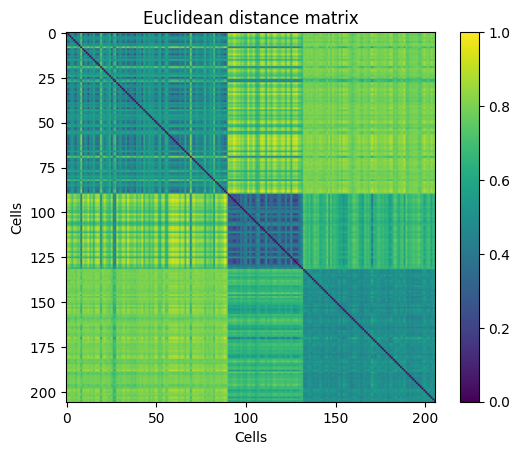

In [17]:
plt.imshow(D_eu[idx][:,idx])
plt.title('Euclidean distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

### Calcul de la matrice de distances OT (Optimal Transport)

Pour calculer la **matrice de distances basée sur le transport optimal (OT)**, nous procédons en deux étapes principales :

1. **Normalisation des cellules**  
   - Chaque colonne (cellule) est divisée par sa somme totale.  
   - Cela transforme les valeurs d'expression en **distributions de probabilité**, car l’OT nécessite que ses entrées soient des distributions (sommant à 1).
   - Pour l’Optimal Transport, chaque cellule doit être une distribution.

2. **Calcul de la matrice de coût et de la distance OT**  
   - On définit d’abord une **matrice de coût** entre les features (gènes), qui mesure “le coût de transporter la masse” d’un gène à un autre.  
   - Ici, nous utilisons la **similarité cosinus** pour définir les coûts, mais il est possible de remplacer cette fonction par une autre métrique adaptée.  
   - À partir de cette matrice de coût et des distributions normalisées, on calcule la **matrice de distances OT**, qui quantifie la dissimilarité entre chaque paire de cellules.

**Remarque** : L’OT est particulièrement utile pour capturer les différences **structurales et globales** entre profils cellulaires, contrairement aux distances classiques comme l’euclidienne.


#### Normalisation

In [18]:
# Per-cell normalization (mandatory)
# L’OT calcule souvent la distance entre les distributions des cellules, donc chaque cellule doit correspondre à une ligne représentant sa distribution de gènes.
data_norm = adata.X.T.astype(np.double) #  c'est pourquoi on fait la transposition, np.double pour ameliorer la precision en float
data_norm

array([[9.20457114, 9.50779464, 9.6329952 , ..., 0.        , 0.        ,
        0.        ],
       [8.31741261, 8.29462075, 8.21916852, ..., 0.        , 0.        ,
        0.        ],
       [8.78463485, 8.79441587, 8.43045255, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.5849625 , 7.24792751, 6.67242534, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 5.169925  , 2.5849625 , ..., 6.64385619, 6.62935662,
        6.59991284],
       [7.59991284, 7.45121111, 7.94251451, ..., 4.169925  , 0.        ,
        0.        ]], shape=(1000, 206))

In [19]:
data_norm.sum(0)

array([5532.68559979, 5729.24284337, 5944.3209279 , 4867.44763467,
       6055.73958852, 5990.59557574, 5772.6813456 , 6310.59733994,
       5740.05370357, 5755.16381259, 3744.83845444, 3658.2736431 ,
       5493.4074956 , 5662.16267908, 3684.01510134, 4252.61111576,
       5927.24137238, 5356.92612404, 4294.95600381, 4843.12640647,
       3783.3799597 , 6198.42862198, 5423.78933145, 1652.0686205 ,
       4530.50669786, 2555.66698442, 5900.65158267, 4991.6766507 ,
       5296.99637069, 5327.99220544, 5407.80978697, 6495.20899764,
       4135.08726581, 4916.5701814 , 5212.04809971, 3284.72157334,
       4993.267049  , 5399.90854085, 5048.90956188, 5193.21211824,
       4665.58068827, 5960.42253419, 4717.70177048, 3989.90415346,
       5720.86951594, 5056.26095771, 5746.55543483, 1945.30586651,
       5573.69305817, 6008.98230785, 5555.18699372, 3732.22582726,
       5453.61325585, 4449.20961202, 6168.16285022, 5019.60092023,
       4934.00750876, 4818.60486702, 6071.46946907, 1509.15676

In [20]:
data_norm /= data_norm.sum(0) # On divise chaque colonne (chaque gène) par sa somme
# transformer les valeurs en probabilités par cellule, car l’OT nécessite que les vecteurs soient des distributions.
data_norm

array([[0.00166367, 0.00165952, 0.00162054, ..., 0.        , 0.        ,
        0.        ],
       [0.00150332, 0.00144777, 0.00138269, ..., 0.        , 0.        ,
        0.        ],
       [0.00158777, 0.001535  , 0.00141824, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0008287 , 0.00126508, 0.00112249, ..., 0.00031568, 0.        ,
        0.        ],
       [0.        , 0.00090237, 0.00043486, ..., 0.00209733, 0.0019364 ,
        0.0023915 ],
       [0.00137364, 0.00130056, 0.00133615, ..., 0.00131636, 0.        ,
        0.        ]], shape=(1000, 206))

In [21]:
# Add a small value to avoid numerical errors
data_norm += 1e-9 # On ajoute une très petite valeur pour éviter les erreurs numériques dans le calcul OT
data_norm /= data_norm.sum(0) # on calcule la somme des cellules pour chaque gène qui sert de valeur pour la division
data_norm

array([[1.66367080e-03, 1.65951961e-03, 1.62053692e-03, ...,
        9.99999000e-10, 9.99999000e-10, 9.99999000e-10],
       [1.50332233e-03, 1.44776865e-03, 1.38269221e-03, ...,
        9.99999000e-10, 9.99999000e-10, 9.99999000e-10],
       [1.58776989e-03, 1.53500437e-03, 1.41823602e-03, ...,
        9.99999000e-10, 9.99999000e-10, 9.99999000e-10],
       ...,
       [8.28704861e-04, 1.26507572e-03, 1.12248728e-03, ...,
        3.15680289e-04, 9.99999000e-10, 9.99999000e-10],
       [9.99999000e-10, 9.02375009e-04, 4.34863106e-04, ...,
        2.09732880e-03, 1.93640259e-03, 2.39150174e-03],
       [1.37363865e-03, 1.30055744e-03, 1.33615136e-03, ...,
        1.31635996e-03, 9.99999000e-10, 9.99999000e-10]],
      shape=(1000, 206))

In [22]:
# Somme de chaque colonne
col_sums = data_norm.sum(axis=0)
print("Somme par colonne (gènes) :\n", col_sums)
col_sums.shape

Somme par colonne (gènes) :
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


(206,)

#### Matrice de cout et distance OT
Nous calculons la matrice de coût `C` entre les gènes avec la distance cosinus.  
Ensuite, nous calculons la matrice de distance OT `D_ot` entre toutes les cellules en utilisant `data_norm` et la matrice de coût `C`.  Le paramètre `eps` contrôle la régularisation entropique, et le calcul est effectué sur GPU pour accélérer le traitement.


In [23]:
# Calcul du cout entre les gènes
C = otscomics.cost_matrix(adata.X.T.astype(np.double), 'cosine')  # On peut changer le cosine par une autre distance

In [24]:
# Calcul de la matrice OT
D_ot, errors = otscomics.OT_distance_matrix(
    data=data_norm, cost=C, eps=.1,
    dtype=torch.double, device='cpu'
)
# L’ajout de l’entropie rend le problème plus stable et plus rapide à calculer
# P = matrice de transport (quantité de masse déplacée entre cellules/gènes)
# C = matrice de coût (distance entre gènes)
# ε contrôle le poids de cette entropie

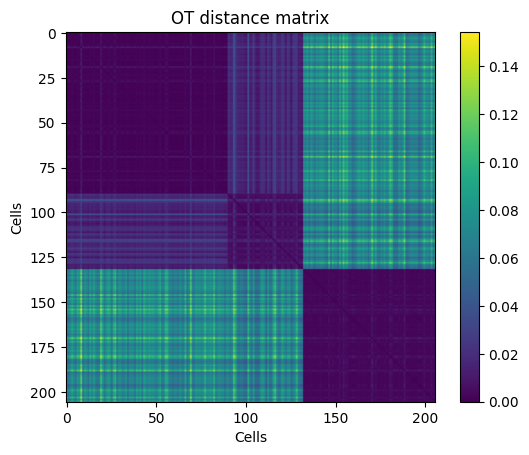

In [25]:
plt.imshow(D_ot[idx][:,idx])
plt.title('OT distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

### Scoring
Nous comparons les matrices de distance Euclidienne (`D_eu`) et OT (`D_ot`) en évaluant la qualité des clusters générés.  
Nous utilisons pour cela des métriques de clustering classiques comme le **Silhouette score**, l’**ARI** et la **NMI**.  
Un score plus élevé indique que la distance choisie permet de mieux séparer les clusters et de regrouper les cellules similaires.


#### Score de Silhouette

In [26]:
print('Euclidean\t',  silhouette_score(D_eu, clusters, metric='precomputed'))
print('OT\t\t',       silhouette_score(D_ot, clusters, metric='precomputed'))

Euclidean	 0.310142677550168
OT		 0.8380411531906462


Le score de Silhouette mesure la cohésion et la séparation des clusters.
Valeur proche de 1 → clusters bien séparés et cohérents.
OT donne un score beaucoup plus élevé que la distance Euclidienne → meilleure séparation des clusters.

#### C index

In [27]:
print('Euclidean\t',  otscomics.C_index(D_eu, clusters))
print('OT\t\t',       otscomics.C_index(D_ot, clusters))

Euclidean	 0.034578119156775076
OT		 0.0023526581284776856


Le C-index mesure la qualité globale du clustering (0 = parfait, 1 = mauvais).
OT a un C-index proche de 0 → meilleure qualité que la distance Euclidienne.

Comparaison des matrices de distance Euclidienne et OT :

- **Silhouette score** : mesure la cohésion et la séparation des clusters. Plus la valeur est proche de 1, mieux les clusters sont séparés.
- **C-index** : mesure globale de la qualité du clustering (0 = parfait, 1 = mauvais).

Résultats :  
- Distance Euclidienne : Silhouette = 0.31, C-index = 0.035  
- Distance OT : Silhouette = 0.84, C-index = 0.0024  

=> La distance OT permet une séparation beaucoup plus nette et une meilleure qualité de clustering que la distance Euclidienne.


### Step:
Maintenant que la matrice de distance OT a montré de meilleurs scores de clustering, les étapes suivantes sont :

1. **Clustering et visualisation** : regrouper les cellules et observer la séparation avec UMAP/t-SNE.  
2. **Annotation des clusters** : identifier les types cellulaires associés aux clusters.  
3. **Analyse différentielle** : déterminer les gènes qui différencient chaque cluster.  
4. **Comparaison avec d'autres méthodes** : valider que l'OT est la meilleure approche pour ce dataset.

Ces étapes permettent de tirer des conclusions biologiques fiables à partir de la structure cellulaire identifiée par OT.


### Clustering hierarchique

In [28]:
cl = AgglomerativeClustering(
    metric='precomputed',
    n_clusters=len(np.unique(clusters)),
    linkage='complete'
)

#### Scoring Euclidean

In [29]:
print('Euclidean')
cl.set_params().fit(D_eu)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean
ARI 0.9215689106896331
NMI 0.9084054726687504
AMI 0.9075477330695366


#### Scoring OT

In [30]:
print('OT')
cl.set_params().fit(D_ot)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT
ARI 1.0
NMI 1.0
AMI 1.0


Clustering hiérarchique et scoring :

- ARI (Adjusted Rand Index) : mesure la concordance entre les clusters prédits et les clusters vrais, corrigée pour le hasard (1 = parfait, 0 = hasard).

- NMI (Normalized Mutual Information) : mesure l’information mutuelle normalisée entre clusters prédits et vrais (1 = parfait).

- AMI (Adjusted Mutual Information) : similaire à NMI mais corrigée pour le hasard.

- **Euclidean** : ARI ≈ 0.92, NMI ≈ 0.91, AMI ≈ 0.91  
- **Optimal Transport (OT)** : ARI = 1.0, NMI = 1.0, AMI = 1.0  

=> La distance OT permet une identification parfaite des clusters, alors que la distance Euclidienne, bien que performante, fait quelques erreurs de regroupement.


### Clustering Hierarchique (number of clusters derived deduit directement du score de  silhouette)
#### Euclidean

In [31]:
cl = AgglomerativeClustering(metric='precomputed', linkage='complete')
range_clusters, sil = range(3, 26), []
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_eu)
  sil.append(silhouette_score(D_eu, cl.labels_, metric='precomputed'))
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_eu)
print('Euclidean,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))


Euclidean, 3 clusters
ARI 0.9215689106896331
NMI 0.9084054726687504
AMI 0.9075477330695366


### Clustering Hierarchique (number of clusters derived deduit directement du score de  silhouette)
#### OT

In [32]:
cl = AgglomerativeClustering(metric='precomputed', linkage='complete')
range_clusters, sil = range(3, 26), []
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_ot)
  sil.append(silhouette_score(D_ot, cl.labels_, metric='precomputed'))
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_ot)
print('OT,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT, 3 clusters
ARI 1.0
NMI 1.0
AMI 1.0


### A typical single-cell clustering based on Leiden
Dans l’analyse single-cell, on ne travaille pas directement sur toutes les distances entre cellules, mais souvent sur un graphe de voisinage (kNN) :

- On construit un réseau de k plus proches voisins (kNN) pour chaque cellule.

- Chaque cellule est connectée à ses k voisins les plus proches selon une distance choisie (souvent Euclidean sur les composantes PCA).

- Ensuite, on applique Leiden clustering, un algorithme de détection de communautés sur le graphe.

Avantages :

- Plus rapide sur de grands datasets.

- Permet de détecter des structures de communautés complexes.


In [33]:
!pip install leidenalg


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


#### PCA + euclidean + kNN + Leiden

In [34]:
print('PCA + euclidean + kNN + Leiden')
sc.pp.pca(adata)
sc.pp.neighbors(adata)
resolutions = np.linspace(.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []
# Iterate through resolutions
print('Iterating through resolutions...')
for resolution in tqdm(resolutions):
  sc.tl.leiden(adata, resolution=resolution)
  if len(np.unique(adata.obs['leiden'])) > 1:
    sils.append(silhouette_score(D_ot, adata.obs['leiden'], metric='precomputed'))
    aris.append(adjusted_rand_score(clusters, adata.obs['leiden']))
    nmis.append(normalized_mutual_info_score(clusters, adata.obs['leiden']))
    amis.append(adjusted_mutual_info_score(clusters, adata.obs['leiden']))
    n_clusters.append(len(np.unique(adata.obs['leiden'])))
  else:
    sils.append(-1)
    aris.append(-1)
    amis.append(-1)
    nmis.append(-1)
    n_clusters.append(-1)
# Max silhouette score
print('Resolution selected by silhouette score')
i = np.argmax(sils)
print('Resolution', resolutions[i])
print('ARI', aris[i])
print('NMI', nmis[i])
print('AMI', amis[i])
print('nb clusters', n_clusters[i])

PCA + euclidean + kNN + Leiden


/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iterating through resolutions...


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_7060/2639833264.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution)
100%|██████████| 20/20 [00:00<00:00, 34.45it/s]

Resolution selected by silhouette score
Resolution 0.25
ARI 0.921697966842453
NMI 0.8963498310700888
AMI 0.89537886590347
nb clusters 3


#### OT + kNN + Leiden

In [36]:
print('OT + kNN + Leiden')
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
n_neighbors = 15
n_cells = D_ot.shape[0]
connectivities = np.zeros((n_cells, n_cells))
distances = np.zeros((n_cells, n_cells))
# Remplir avec les kNN
for i in range(n_cells):
    connectivities[i, knn_indices[i]] = 1
    distances[i, knn_indices[i]] = knn_dists[i]
# Convertir en sparse
connectivities = csr_matrix(connectivities)
distances = csr_matrix(distances)
# Ajouter à AnnData
adata.obsp['connectivities'] = connectivities
adata.obsp['distances'] = distances


OT + kNN + Leiden


NameError: name 'knn_indices' is not defined

In [ ]:
resolutions = np.linspace(.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []

# Iterate through resolutions
print('Iterating through resolutions...')
for resolution in tqdm(resolutions):
  sc.tl.leiden(adata, resolution=resolution)
  if len(np.unique(adata.obs['leiden'])) > 1:
    sils.append(silhouette_score(D_ot, adata.obs['leiden'], metric='precomputed'))
    aris.append(adjusted_rand_score(clusters, adata.obs['leiden']))
    nmis.append(normalized_mutual_info_score(clusters, adata.obs['leiden']))
    amis.append(adjusted_mutual_info_score(clusters, adata.obs['leiden']))
    n_clusters.append(len(np.unique(adata.obs['leiden'])))
  else:
    sils.append(-1)
    aris.append(-1)
    amis.append(-1)
    nmis.append(-1)
    n_clusters.append(-1)

# Max silhouette score
print('Resolution selected by silhouette score')
i = np.argmax(sils)

print('Resolution', resolutions[i])
print('ARI', aris[i])
print('NMI', nmis[i])
print('AMI', amis[i])
print('nb clusters', n_clusters[i])

## Debut du projet

LA question maintenant que l'on se pose pour aller plus loin dans ce travail que nous avons deja commencé consiste à utiliser l'OT pour construire des features. il s'agit principalement de de repondre à la question suivante:
- Comment représenter chaque cellule par de nouvelles variables construites à partir de l’OT ?
- 
jusqu'a present ce qui a été fait consistait principalement à utilser les cellules deja existantes pour appliquer l'OT.

-Donc notre objectif dans un premier temps consiste à utiliser l'OT pour créer de nouvelles variables à partir des cellules existentes pour ensuite appliquer les méthodes que nous avons deja vu pour amleliorer la qualité des clusters bien qu'elle soit deja bien comme ce qui a été déja fait dans l'article de reference.

- Avant on considerait chaque cellule comme étant une combinaison de gene.
- Desormais on essaiera de construire à partir de l'OT de nouveaux vecteurs.

Pour créer ces features, il faudra alors definir de nombreux facons de le faire:

- Une première facon consistera à definir une distance vers quelque chose de fixe qui representera une feature.
- Méthode 1 — Features = distances OT vers des cellules de référence (la plus simple)
Nous construisons de nouvelles features en représentant chaque cellule par ses distances OT à un ensemble de cellules de référence.  
Ainsi, chaque cellule est décrite par un vecteur de distances OT, capturant sa similarité globale avec différentes populations cellulaires.

- Méthode 2 — Features = distances OT vers les clusters (encore mieux)
On utilise les clusters OT; Tu choisis un représentant par cluster (médiane ou barycentre OT); Feature j = distance OT de la cellule au cluster j;

Au-delà de son usage comme métrique de similarité, l’Optimal Transport permet de construire de nouvelles représentations des cellules.  
Chaque cellule peut être décrite par ses distances OT à des cellules ou clusters de référence, ou via un embedding construit à partir de la matrice OT.  
Ces OT-features capturent la structure globale des données et améliorent les performances de clustering et d’annotation.





### Construction des features: 1 ere méthode

In [37]:
X_ot = D_ot.copy()
print(X_ot.shape)

(206, 206)


In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X_ot_pca = pca.fit_transform(X_ot)
print(X_ot_pca.shape)

(206, 30)


La matrice de distances OT fournit une représentation de chaque cellule sous
la forme d’un vecteur de distances vers l’ensemble des autres cellules.
Afin de réduire la dimension de cette représentation, une analyse en
composantes principales (ACP) a été appliquée à la matrice OT, et les 30
premières composantes ont été retenues. Ces composantes constituent les
features finales utilisées pour le clustering et l’analyse


### Construction du graphe de voisinage (kNN)

In [39]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 15
nbrs = NearestNeighbors(n_neighbors=n_neighbors)
nbrs.fit(X_ot_pca)  # features OT réduites
knn_dists, knn_indices = nbrs.kneighbors(X_ot_pca)


### Clustering

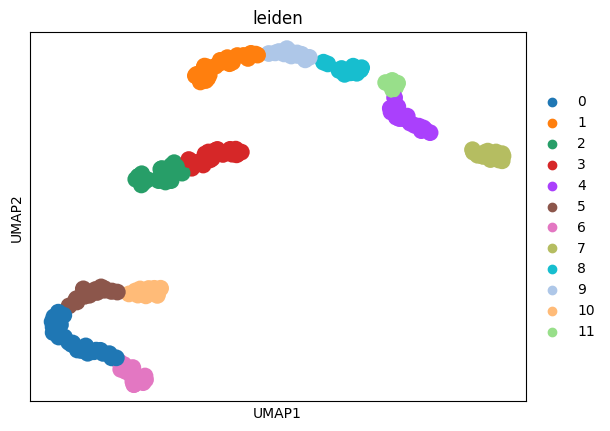

In [41]:
import scanpy as sc
adata.obsm['X_ot'] = X_ot_pca
sc.pp.neighbors(adata, use_rep='X_ot')
sc.tl.leiden(adata, resolution=1.0)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden')


### Scoring 

In [43]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

ari = adjusted_rand_score(clusters, adata.obs['leiden'])
sil = silhouette_score(X_ot_pca, adata.obs['leiden'])
print(ari, sil)

0.29534229291902786 0.4605388971751534


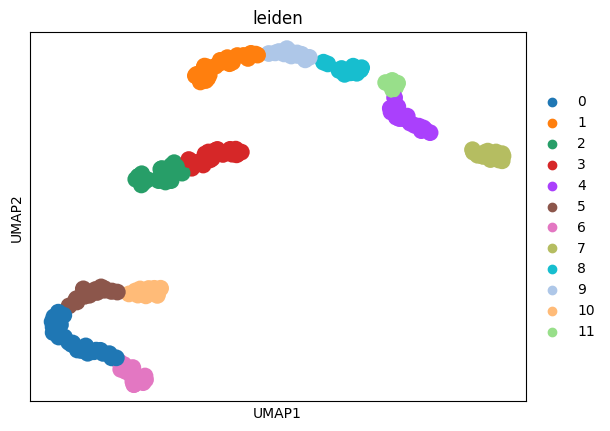

In [44]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden')


In [47]:
import pandas as pd

# Créer un mapping cluster -> label majoritaire
mapping = {}
for c in np.unique(adata.obs['leiden']):
    labels_in_cluster = adata.obs['cell_line'][adata.obs['leiden'] == c]
    majority_label = labels_in_cluster.value_counts().idxmax()
    mapping[c] = majority_label

# Ajouter les labels annotés
adata.obs['leiden_annot'] = adata.obs['leiden'].map(mapping)


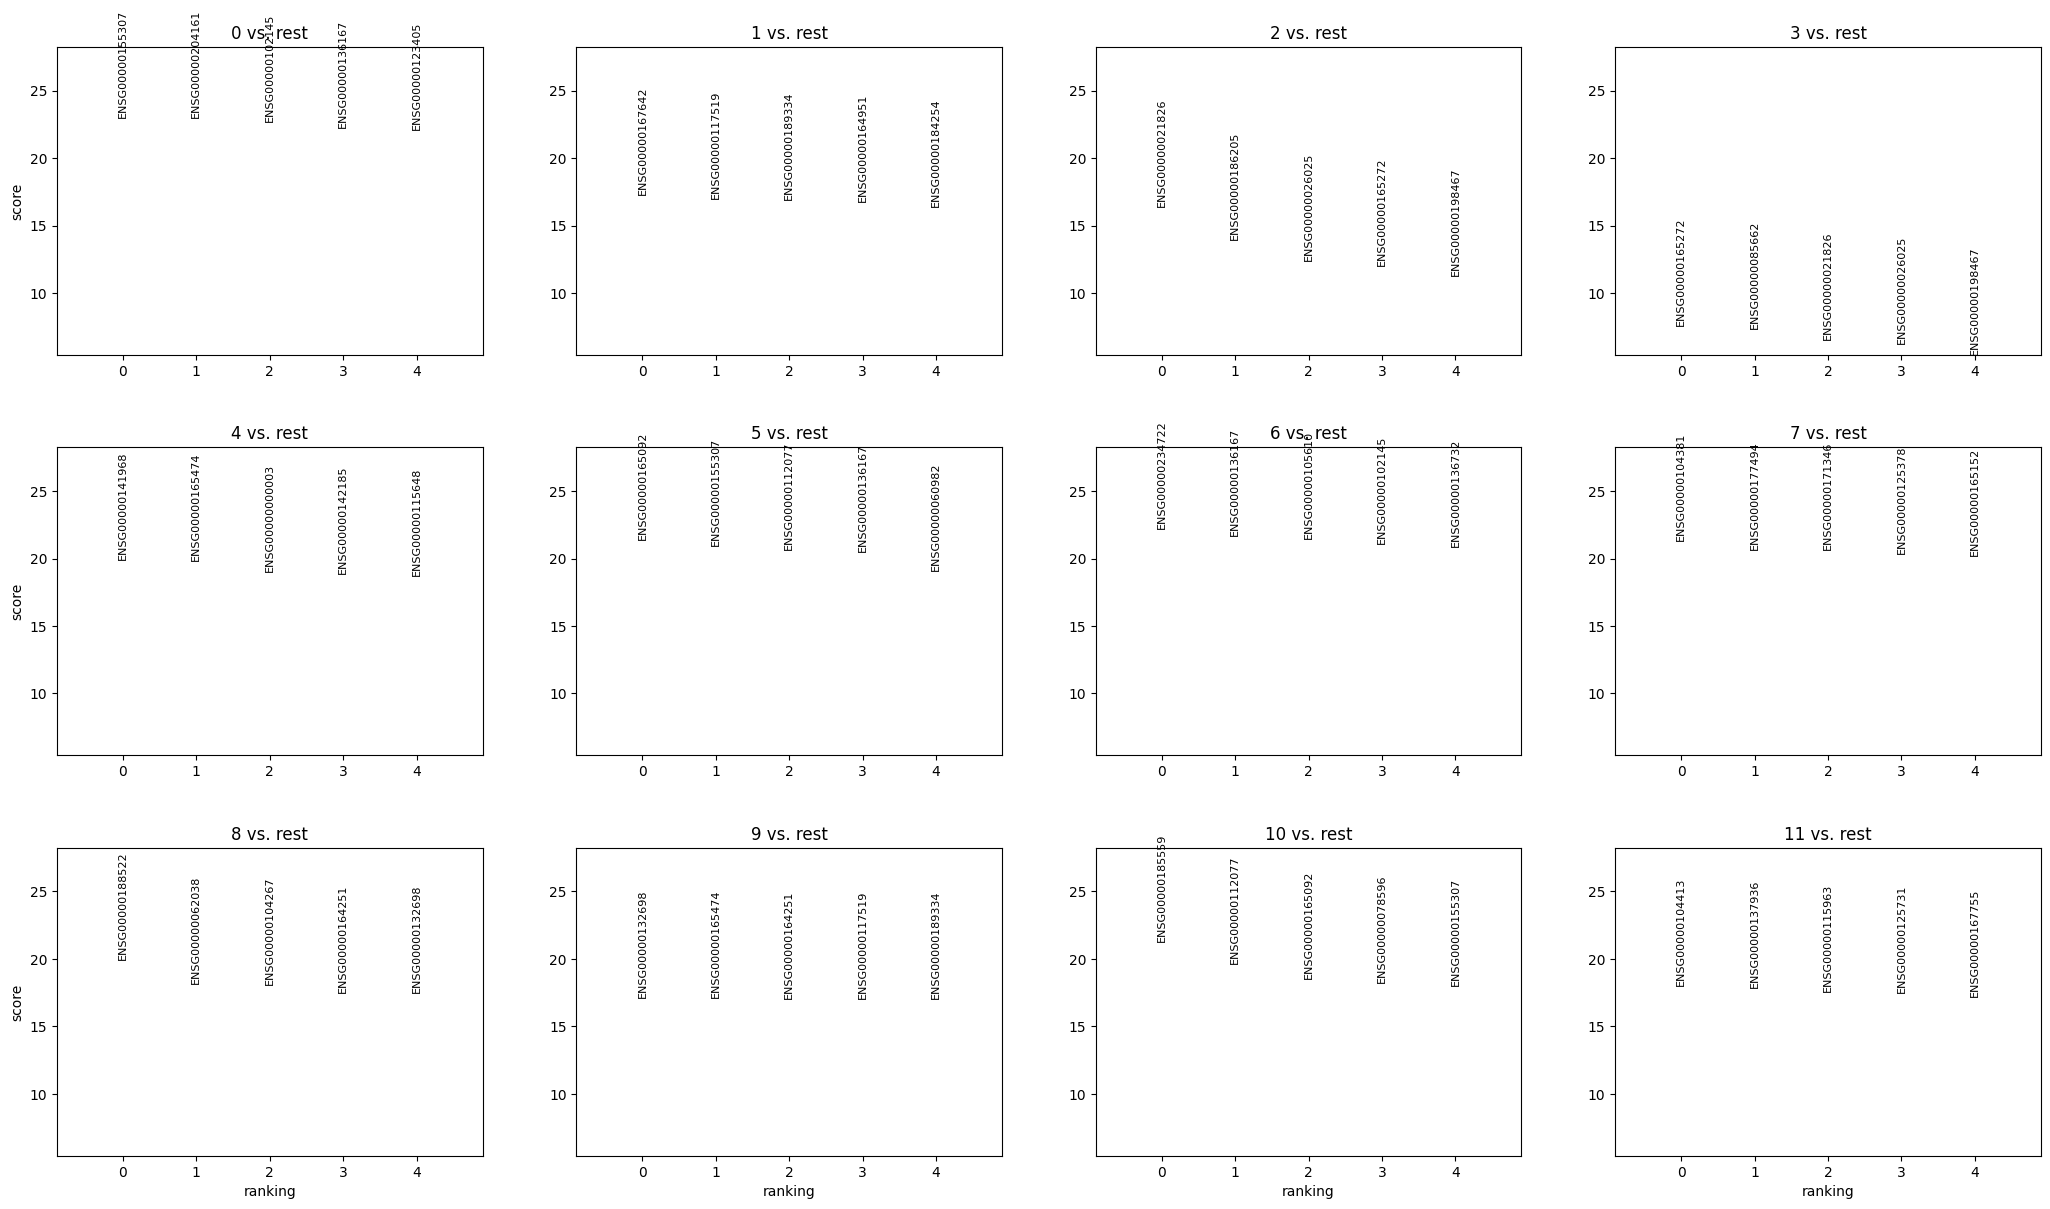

In [48]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=5)
